# Testing out a toy data set with custom loss

Goal: 
1. Test if it can over fit with 1000 images
2. Test if changing the loss function to a hybrid histogram + perceptual loss will improve this

In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, models as torchvision_models
from torch.utils.data import Dataset, DataLoader
import timm
import pandas as pd
from PIL import Image
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
from diffusers import StableDiffusionPipeline, AutoencoderKL, DiffusionPipeline

from torchvision.models import vgg16

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 1000
        # return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))

class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

def color_histogram_loss(output, target, bins=256, min_value=0, max_value=1):
    hist_loss = 0.0
    for channel in range(3):
        output_hist = torch.histc(output[:, channel, :, :], bins=bins, min=min_value, max=max_value)
        target_hist = torch.histc(target[:, channel, :, :], bins=bins, min=min_value, max=max_value)
        output_hist /= output_hist.sum()
        target_hist /= target_hist.sum()
        hist_loss += torch.norm(output_hist - target_hist, p=2)
    return hist_loss / 3

class Colorizer(LightningModule):
    def __init__(self, vae):
        super().__init__()
        self.model = vae
        vgg_model = vgg16(weights=True)
        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.hparams.learning_rate = 0.00001

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs).sample
        perceptual_loss = self.loss_fn(outputs, targets)
        histogram_loss = color_histogram_loss(outputs, targets)
        total_loss = perceptual_loss + histogram_loss * 2  # You can also use weights here if needed
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('histogram_loss', histogram_loss)
        return total_loss

In [3]:
vae = torch.load('anything-vae.pth', map_location='cpu')

In [4]:
chkpt_file = 'checkpoints/version_68.ckpt'
model = Colorizer.load_from_checkpoint(chkpt_file, vae=vae, map_location='cpu')

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
data_folder = 'data/toy'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)

In [6]:
logger = loggers.TensorBoardLogger("tb_logs")
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(model, dataloader)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory tb_logs/lightning_logs/version_72/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | AutoencoderKL     | 83.7 M
1 | loss_fn | VGGPerceptualLoss | 138 M 
----------------------------------------------
220 M     Trainable params
1.7 M     Non-trainable params
222 M     Total params
888.046   Total estimated model params size (MB)
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:42<00:00,  1.72it/s, v_num=72]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:48<00:00,  1.70it/s, v_num=72]


In [58]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [59]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          

In [88]:
idx = 9831
x, y = test_dataset[idx]
output = model(x.unsqueeze(0))

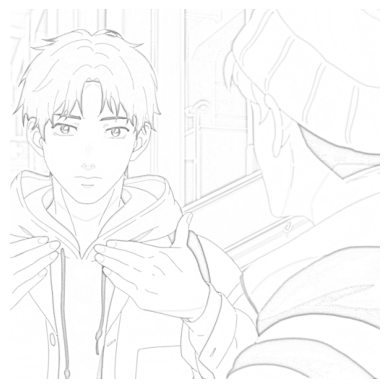

In [89]:
viewTensor(x)

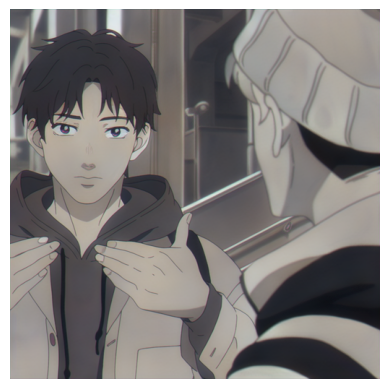

In [90]:
viewTensor(output.sample)

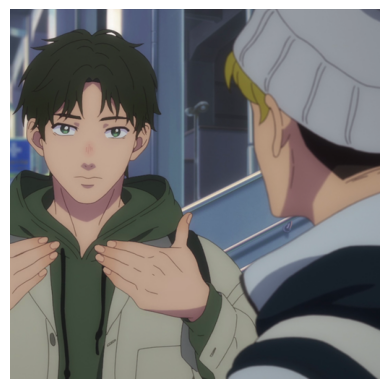

In [91]:
viewTensor(y)

In [61]:
idx = 1013
x, y = test_dataset[idx]
output = model(x.unsqueeze(0))